# Project 1 - timelines
---
Assumption: all the Time mentioned here is from BST timezone (The United Kingdom)

### Conclusions:
 - There are two peeks of fraud during the day:
  - 0 AM - 6 AM and 13 AM
  - percentage of the amount of fraud transactions out of the total transaction amount for a specific time of the day is greater than the percentage of the fraud transaction count out of the total transaction count for the same time of the day, which could mean that on average fraud transactions are of a higher value than other transactions
  - Fraud Count correlate with Fraud Amount, which mean that on average the values of fraud transaction for a day X time is more of less consistent, which could mean in its turn that there might be some specific segment of profiles affected the most. Also we can use this info to concentrate on either of the above metric rather then on both of them



In [210]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from pathlib import Path
import numpy as np
import seaborn as sns

# Study data files
f_path = Path("Resources/cleaned_data.csv")

# Read the mouse data and the study results
cleaned_data = pd.read_csv(f_path, index_col=0)

# Display the data table for preview
cleaned_data.head()

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount (in £),Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,3577209,2020-10-14,Wednesday,19,Visa,Tap,5.0,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25,RBS,0
1,3039221,2020-10-14,Wednesday,17,MasterCard,PIN,288.0,POS,Services,USA,USA,USA,F,49,Lloyds,0
2,2694780,2020-10-14,Wednesday,14,Visa,Tap,5.0,POS,Restaurant,India,India,India,F,42,Barclays,0
3,2640960,2020-10-13,Tuesday,14,Visa,Tap,28.0,POS,Entertainment,United Kingdom,India,United Kingdom,F,51,Barclays,0
4,2771031,2020-10-13,Tuesday,23,Visa,CVC,91.0,Online,Electronics,USA,USA,United Kingdom,M,38,Halifax,1


In [211]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99977 entries, 0 to 99976
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transaction ID          99977 non-null  int64  
 1   Date                    99977 non-null  object 
 2   Day of Week             99977 non-null  object 
 3   Time                    99977 non-null  int64  
 4   Type of Card            99977 non-null  object 
 5   Entry Mode              99977 non-null  object 
 6   Amount (in £)           99977 non-null  float64
 7   Type of Transaction     99977 non-null  object 
 8   Merchant Group          99977 non-null  object 
 9   Country of Transaction  99977 non-null  object 
 10  Shipping Address        99977 non-null  object 
 11  Country of Residence    99977 non-null  object 
 12  Gender                  99977 non-null  object 
 13  Age                     99977 non-null  int64  
 14  Bank                    99977 non-null

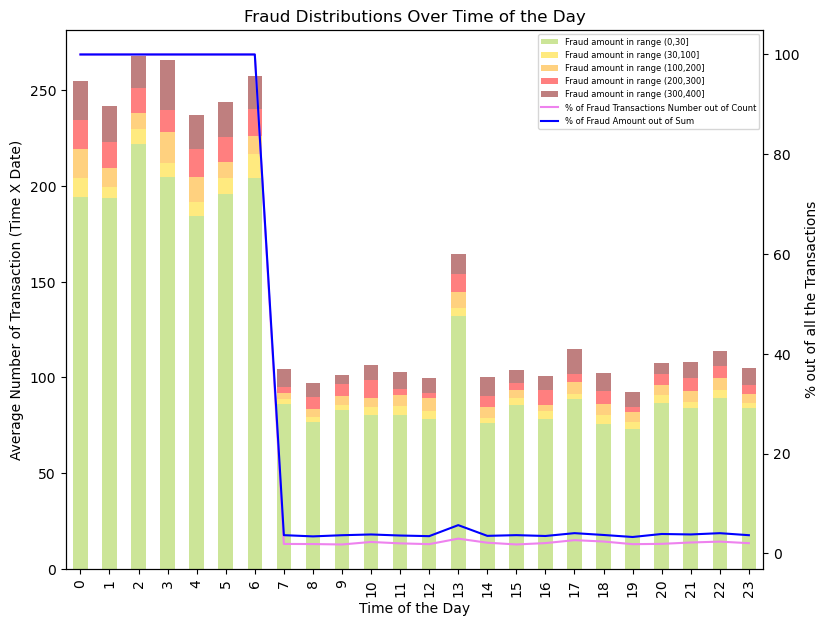

In [212]:
# AVG count of transactions for a day option

# leave only Tuesday and Wednesday
cleaned_data=cleaned_data[(cleaned_data["Day of Week"]=="Tuesday")|(cleaned_data["Day of Week"]=="Wednesday")]

size_bins = [0, 30, 100, 200, 300, 400]
labels = ["Fraud amount in range (0,30]", "Fraud amount in range (30,100]", "Fraud amount in range (100,200]", "Fraud amount in range (200,300]", "Fraud amount in range (300,400]"]
colors=["yellowgreen", "gold", "orange", "red", "maroon"]  #https://matplotlib.org/stable/gallery/color/named_colors.html
cleaned_data["Fraud Size"] = pd.cut(cleaned_data["Amount (in £)"], bins=size_bins, labels=labels)

data_stecked=cleaned_data.loc[cleaned_data["Fraud"]==1,["Time", "Fraud Size"]].copy()
data_stecked=data_stecked.groupby(["Time", "Fraud Size"]).size()
data_stecked=pd.DataFrame(data_stecked).rename(columns={0:"Size Count"}).reset_index()


#find averages
day_count=cleaned_data["Date"].nunique()

for i, row in data_stecked.iterrows():
    data_stecked.loc[i,"Size Count"]=row["Size Count"]/day_count

# switch Fraud Size column to a row
data_stecked = data_stecked.pivot(index='Time', columns='Fraud Size', values='Size Count').fillna(0)

# create shared figuer and x axis
fig, ax = plt.subplots(figsize=(6,5))

# Create the stacked bar chart
data_stecked.plot(kind='bar', stacked=True, ax=ax, color=colors, figsize=(9, 7), alpha=0.5, legend=False)


def perc(df, col1, col2, res_col1, res_col2):
    df[res_col1]=""
    df[res_col2]=""
    for i, row in df.iterrows():
        sum_c=row[col1]+row[col2]
        df.loc[i,res_col1]=100*row[col1]/sum_c
        df.loc[i,res_col2]=100*row[col2]/sum_c
    return df

area_df1=cleaned_data.groupby(["Time","Fraud"]).size()
area_df1=pd.DataFrame(area_df1).reset_index().rename(columns={0:"Transaction Count"}).set_index("Time")
area_df1=area_df1.pivot(columns='Fraud', values='Transaction Count').fillna(0)
area_df1=perc(area_df1, 0,1,"Genuine Count %","Fraud Count %")

area_df2=cleaned_data.groupby(["Time","Fraud"])["Amount (in £)"].sum()
area_df2=pd.DataFrame(area_df2).reset_index().rename(columns={"Amount (in £)":"Transaction Amount"}).set_index("Time")
area_df2=area_df2.pivot(columns='Fraud', values='Transaction Amount').fillna(0)
area_df2=perc(area_df2, 0,1,"Genuine Amount %","Fraud Amount %")

ax2=ax.twinx()
l1=area_df2.plot(y=["Fraud Amount %"], ax=ax2, color="violet", legend=False)
area_df1.plot(y=["Fraud Count %"], ax=ax2, color="blue", legend=False) 
# add source here
l1.get_lines()[0].set_label("% of Fraud Transactions Number out of Count")
l1.get_lines()[1].set_label("% of Fraud Amount out of Sum")


ax.set_ylabel("Average Number of Transaction (Time X Date)")
ax2.set_ylabel("% out of all the Transactions")
ax.set_xlabel("Time of the Day")
ax.set_title("Fraud Distributions Over Time of the Day")

# add legend for all charts https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="best",prop={'size': 6})


The r-value is:0.8079918305382258


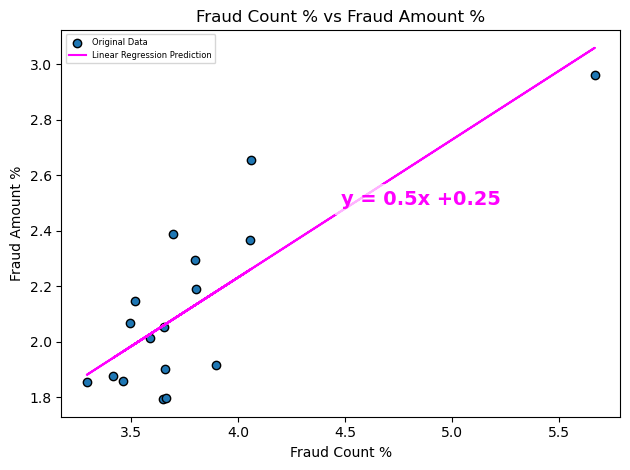

In [214]:
df_merged_perc=pd.merge(area_df1[["Genuine Count %","Fraud Count %"]],area_df2[["Genuine Amount %","Fraud Amount %"]], left_index=True, right_index=True)
df_merged_perc.reset_index()
df_merged_perc["Fraud Count %"]=df_merged_perc["Fraud Count %"].astype("float")
df_merged_perc["Fraud Amount %"]=df_merged_perc["Fraud Amount %"].astype("float")
df_merged_perc=df_merged_perc[~(df_merged_perc["Fraud Count %"]==100)]
df_merged_perc
# Define a function to create Linear Regression plots
def lin_reg(x, y, x_label, y_label):
    slope, b, lin_corr, _, _ = st.linregress(x,y)
    pred=slope*x+b
    
    #print r-value
    print(f"The r-value is:{lin_corr}")

    # Create line equation string
    if abs(round(slope,2))>0: eq=f"y = {round(slope,2)}x +{round(b,2)}"
    else: #we want to omit y=0.0x+b situation
        non_zero_decimal_position=2
        decimals=str(slope).split(".")[1] #https://www.softwaretestinghelp.com/python/python-string-split/
        i=decimals[2] #https://buzzcoder.gitbooks.io/codecraft-python/content/string/loop-through-a-string.html
        while i=='0': 
            non_zero_decimal_position+=1
            i=decimals[non_zero_decimal_position]
        eq=f"y = {round(slope,non_zero_decimal_position+1)}x +{round(b,2)}"
        
    #plot the above regression line along with x_column_name vs y_column_name dependency
    fig, ax = plt.subplots(1,1)
    #plot
    ax.scatter(x=x,y=y, marker="o", edgecolor="black", label="Original Data")
    ax.plot(x,pred, color="fuchsia", label="Linear Regression Prediction")
    #annotation
    x_p=x.max()-(x.max()-x.min())/2
    y_p=slope*x_p+b+(y.max()-y.min())/50
    ax.annotate(eq,(x_p,y_p),fontsize=14, fontweight="bold", color="fuchsia", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    #labels...
    ax.set_xlabel(x_label)
    ax.set_ylabel(f"{y_label}")
    ax.set_title(f"{x_label} vs {y_label}")  
    ax.legend(loc="best",prop={'size': 6})
    plt.tight_layout()
    # Show plot
    plt.show()
    
    
lin_reg(df_merged_perc["Fraud Count %"],df_merged_perc["Fraud Amount %"],"Fraud Count %", "Fraud Amount %")


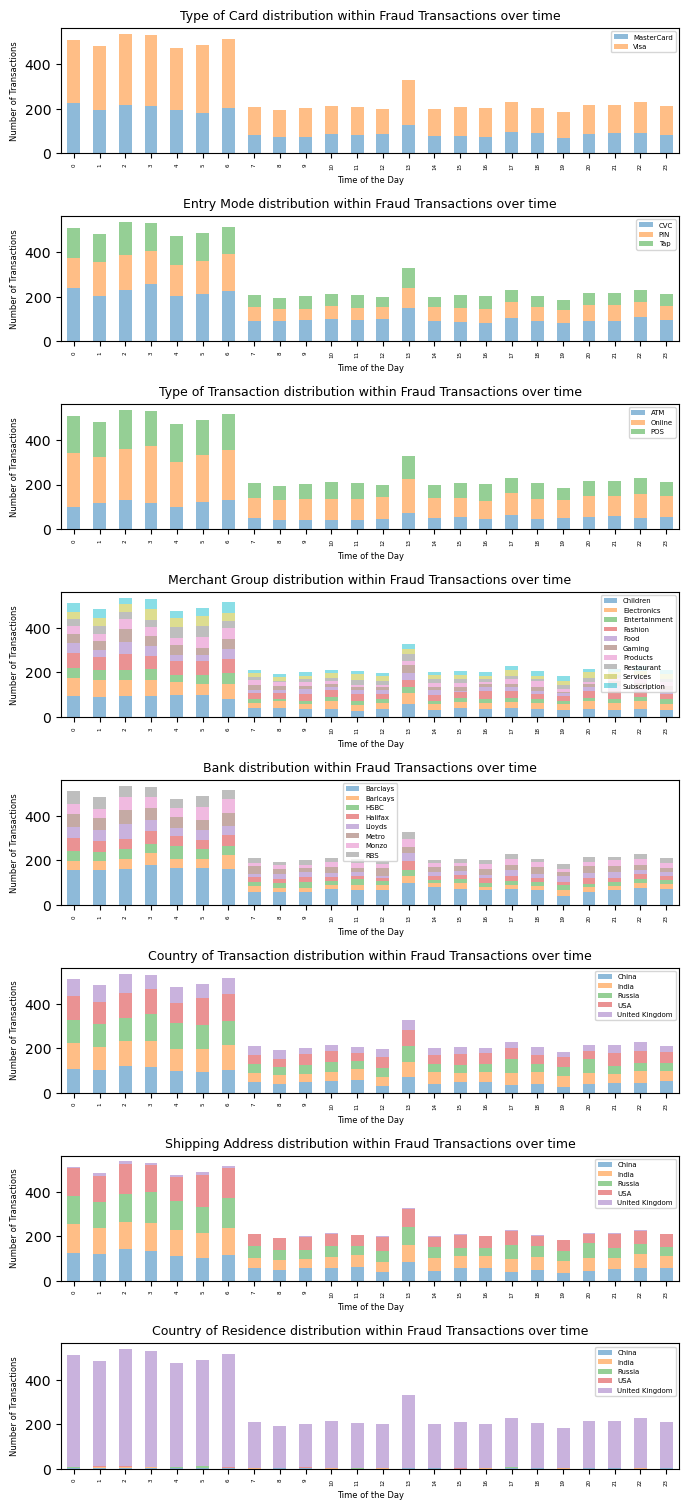

In [253]:
# check distributions of different paramenters over the day
#create a function for building of bar charts
def stacked_bars(df, x_column, y_column, y_values, ax):
    df_stecked=df.loc[:,[x_column, y_column]].copy()
    df_stecked=df_stecked.groupby([x_column, y_column]).size()
    df_stecked=pd.DataFrame(df_stecked).rename(columns={0:y_values}).reset_index()
  # switch Fraud Size column to a row
    df_stecked = df_stecked.pivot(index=x_column, columns=y_column, values=y_values).fillna(0)

  # Create the stacked bar chart
    df_stecked.plot(kind='bar', stacked=True, ax=ax, alpha=0.5)
    ax.tick_params(axis='x', labelsize=4)
    ax.set_title(f"{y_column} distribution within Fraud Transactions over time", size=9)
    ax.set_ylabel("Number of Transactions", size=6)
    ax.set_xlabel("Time of the Day", size=6)
    ax.legend(loc="best",prop={'size': 5})

#working with only fraud data
fraud_df=cleaned_data.loc[cleaned_data["Fraud"]==1].copy()

fig, ax = plt.subplots(8, 1, figsize=(7, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)

# building stacked bars:
stacked_bars(fraud_df, "Time", "Type of Card", "Count of Transactions", ax[0])
stacked_bars(fraud_df, "Time", "Entry Mode", "Count of Transactions",  ax[1])
stacked_bars(fraud_df, "Time", "Type of Transaction", "Count of Transactions",  ax[2])
stacked_bars(fraud_df, "Time", "Merchant Group", "Count of Transactions",  ax[3])
stacked_bars(fraud_df, "Time", "Bank", "Count of Transactions",  ax[4])
stacked_bars(fraud_df, "Time", "Country of Transaction", "Count of Transactions",  ax[5])
stacked_bars(fraud_df, "Time", "Shipping Address", "Count of Transactions",  ax[6])
stacked_bars(fraud_df, "Time", "Country of Residence", "Count of Transactions",  ax[7])
